In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import getpass
from IPython.display import display
import json
import nltk
import numpy as np
import pandas as pd
import pkg_resources
import os
import random
import re
import seaborn as sns
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow.python.lib.io import file_io

In [8]:
from utils_export.dataset import Dataset, Model
from utils_export import utils_cloudml
from utils_export import utils_tfrecords

In [9]:
# Faster to access GCS file:
# https://github.com/tensorflow/tensorflow/issues/15530
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '0'

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/msushkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
def tokenizer(text, lowercase=True):
  """Converts text to a list of words.

  Args:
    text: piece of text to tokenize (string).
    lowercase: whether to include lowercasing in preprocessing (bool).

  Returns:
    A list of strings (words).
  """
  words = nltk.word_tokenize(text.decode('utf-8'))
  if lowercase:
    words = [w.lower() for w in words]
  return words

In [8]:
def make_test_input_fn(dataset_path,
                       model_text_feature,
                       dataset_text_feature,
                       data_label,
                       tokenizer_fn,
                       label_data_type=tf.float32,
                       max_n_examples=None,
                       random_filter_keep_rate=1.0):
    """Returns a test input function.
    
    Args:
      dataset_path (str): Path to dataset.
      model_text_feature (str): The feature column corresponding to the
        text input the model expects.
      dataset_text_feature (str): The name of the text feature of the dataset.
      data_label (str): The output label for the dataset.
      tokenizer_fn: Tokenizer function (str -> list).
      max_n_examples (int): How many examples to evaluate on.
      random_filter_keep_rate (float): Filter out test examples with this probability.

    Returns:
      Test input function.
    """
    decoding_input_features = {
      dataset_text_feature: tf.FixedLenFeature([], dtype=tf.string),
      data_label: tf.FixedLenFeature([], dtype=label_data_type)
    }

    def test_input_fn(max_n_examples=max_n_examples,
                      random_filter_keep_rate=random_filter_keep_rate):
        """Test input function.
        
        Args:
          max_n_examples (int): How many examples to evaluate on.
          random_filter_keep_rate (float): Filter out test examples with this probability.
          
        Returns:
          DataFrame with the results.
        """
        res = utils_tfrecords.decode_tf_records_to_pandas(
            decoding_input_features,
            dataset_path,
            max_n_examples,
            random_filter_keep_rate)
        if not tokenizer_fn:
            tok = lambda x: [x]
            res[model_text_feature] = list(map(tok, res[dataset_text_feature]))
        else:
            res[model_text_feature] = list(map(tokenizer_fn, res[dataset_text_feature]))
        res = res.rename(columns={ data_label: 'label' })
        res['label'] = list(map(lambda x: bool(round(x)), list(res['label'])))
        final = res.copy(deep=True)
        return final

    return test_input_fn

In [9]:
def print_results(results_df, model_names, print_pr_curve=False):
    """Print the classification results.
    
    Args:
      results_df: DataFrame with the results.
      model_names: List of strings representing the models for which we have results.
    """
    labels = results_df['label']
    for _model in model_names:
        print(_model)
        model_preds = results_df[_model]
        fpr, tpr, thresholds = metrics.roc_curve(labels, model_preds)
        roc_auc = metrics.auc(fpr, tpr)
        recalls, precisions, thr = metrics.precision_recall_curve(labels, model_preds)
        pr_auc = metrics.auc(precisions, recalls)
        model_preds_binary = (model_preds > 0.5).astype(np.int_)
        f1 = metrics.f1_score(labels, model_preds_binary)
        print('\tROC AUC: {}'.format(roc_auc))
        print('\tPR AUC: {}'.format(pr_auc))
        print('\tF1: {}'.format(f1))

In [10]:
PROJECT_NAME = 'conversationai-models'
SENTENCE_KEY = 'comment_key' #Input key

# Pattern for path of tf_records
OUTPUT_DIR_BASE = os.path.join(
    'gs://conversationai-models',
    getpass.getuser(),
    'tfrecords')

## Evaluate models on Civil Comments dataset

In [175]:
LABEL_NAME_PREDICTION_MODEL = 'toxicity/logistic'
DATASET = 'gs://conversationai-models/resources/civil_comments_data/train_eval_test/test-*.tfrecord'
DATA_LABEL = 'toxicity'
DATASET_TEXT_FEATURE='comment_text'

# Pattern for path of tf_records
OUTPUT_DIR = os.path.join(OUTPUT_DIR_BASE, 'civil_comments_test')

### CNN, GRU Attention Models

In [140]:
MODEL_TEXT_FEATURE = 'tokens'
MODEL_NAMES = [
    'tf_cnn_civil_comments_glove:v_20190219_185541',
    'tf_gru_attention_civil_comments_glove:v_20190219_185619',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

test_input_fn = make_test_input_fn(
    DATASET, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR)
test_dataset.load_data(10000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [143]:
civil_comments_test_df = test_dataset.show_data()

In [144]:
print_results(civil_comments_test_df, MODEL_NAMES)

tf_cnn_civil_comments_glove:v_20190219_185541
	ROC AUC: 0.9573435242534393
	PR AUC: 0.6729934425219886
tf_gru_attention_civil_comments_glove:v_20190219_185619
	ROC AUC: 0.9649161132104584
	PR AUC: 0.7486011745102973


### TF-Hub Model

In [189]:
MODEL_TEXT_FEATURE = 'text'
MODEL_NAMES = [
    'tf_hub_classifier_civil_comments:v20190322_142141_21201_1553344552',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

test_input_fn = make_test_input_fn(
    DATASET, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR)
test_dataset.load_data(10000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [193]:
civil_comments_hub_df = test_dataset.show_data()

In [194]:
print_results(civil_comments_hub_df, MODEL_NAMES)

tf_hub_classifier_civil_comments:v20190322_142141_21201_1553344552
	ROC AUC: 0.9595451744696132
	PR AUC: 0.7429338592289392


## Evaluate models on Toxicity dataset

In [195]:
LABEL_NAME_PREDICTION_MODEL = 'frac_neg/logistic'
DATASET = 'gs://conversationai-models/resources/toxicity_data/toxicity_q42017_test.tfrecord'
DATA_LABEL = 'frac_neg'
DATASET_TEXT_FEATURE='comment_text'

# Pattern for path of tf_records
OUTPUT_DIR = os.path.join(OUTPUT_DIR_BASE, 'toxicity_test')

### CNN, GRU Attention Models

In [162]:
MODEL_TEXT_FEATURE = 'tokens'
MODEL_NAMES = [
    'tf_cnn_toxicity_glove:v_20190219_185532',
    'tf_gru_attention_toxicity_glove:v_20190219_185516',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

test_input_fn = make_test_input_fn(
    DATASET, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR)
test_dataset.load_data(10000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [149]:
toxicity_test_df1 = test_dataset.show_data()

In [150]:
print_results(toxicity_test_df1, MODEL_NAMES)

tf_cnn_toxicity_glove:v_20190219_185532
	ROC AUC: 0.951760553925346
	PR AUC: 0.8740274773143215
tf_gru_attention_toxicity_glove:v_20190219_185516
	ROC AUC: 0.9543916575133977
	PR AUC: 0.8814208812923074


### TF-Hub Model

In [196]:
MODEL_TEXT_FEATURE = 'text'
MODEL_NAMES = [
    'tf_hub_classifier_toxicity:v20190322_142740_24239_1553555427',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

test_input_fn = make_test_input_fn(
    DATASET, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR)
test_dataset.load_data(10000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [200]:
toxicity_test_df2 = test_dataset.show_data()

In [201]:
print_results(toxicity_test_df2, MODEL_NAMES)

tf_hub_classifier_toxicity:v20190322_142740_24239_1553555427
	ROC AUC: 0.9270843170934745
	PR AUC: 0.8155815559085313


## Evaluate models on Many Communities dataset (full)

In [23]:
LABEL_NAME_PREDICTION_MODEL = 'removed/logistic'
DATASET = 'gs://conversationai-models/resources/transfer_learning_data/many_communities/20181105_answers_all_columns_nthain.tfrecord'
DATA_LABEL = 'removed'
DATASET_TEXT_FEATURE='comment_text'

# Pattern for path of tf_records
OUTPUT_DIR = os.path.join(OUTPUT_DIR_BASE, 'many_communities_test')

### CNN, GRU Attention Models

In [14]:
MODEL_TEXT_FEATURE = 'tokens'
MODEL_NAMES = [
    'tf_cnn_many_communities_glove:v_20190219_185551_gpu_p100_4',
    #'tf_gru_attention_many_communities:v20190322_142800_507893_1556085643',
    #'tf_gru_attention_many_communities:v20190315_161037_23271_1555129264',
    'tf_gru_attention_many_communities:v20190705_004839_507000_1562364428_gpu_p100_4',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

test_input_fn = make_test_input_fn(
    DATASET, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer, label_data_type=tf.int64)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR)
test_dataset.load_data(100000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [318]:
many_communities_test_df = test_dataset.show_data()

In [319]:
print_results(many_communities_test_df, MODEL_NAMES)

tf_cnn_many_communities_glove:v_20190219_185551
	ROC AUC: 0.7476941464055139
	PR AUC: 0.07604839414024091
tf_gru_attention_many_communities:v20190315_161037_23271_1555129264
	ROC AUC: 0.7215269560475308
	PR AUC: 0.06656538517176142


### TF-Hub Model

In [24]:
MODEL_TEXT_FEATURE = 'text'
MODEL_NAMES = [
    'tf_hub_classifier_many_communities:v20190219_185602_316000_1553563221_gpu_v100_4',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

test_input_fn = make_test_input_fn(
    DATASET, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None, label_data_type=tf.int64)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR)
test_dataset.load_data(10000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [16]:
many_communities_tfhub_test_df = test_dataset.show_data()

In [ ]:
print_results(many_communities_tfhub_test_df, MODEL_NAMES)

## Evaluate models on Many Communities subset (adapted for few-shot learning)

In [12]:
LABEL_NAME_PREDICTION_MODEL = 'label/logistic'
DATASET_VALID = 'gs://conversationai-models/resources/transfer_learning_data/many_communities_40_per_8_shot/validation_query..tfrecord'
DATASET_TEST = 'gs://conversationai-models/resources/transfer_learning_data/many_communities_40_per_8_shot/test_query..tfrecord'
DATA_LABEL = 'label'
DATASET_TEXT_FEATURE='text'

### Pessimistic

In [13]:
# Pattern for path of tf_records
OUTPUT_DIR_VALID = os.path.join(OUTPUT_DIR_BASE, 'many_communities_40_per_8_shot/pessimistic/valid')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR_BASE, 'many_communities_40_per_8_shot/pessimistic/test')

#### CNN, GRU Attention Models

In [13]:
MODEL_TEXT_FEATURE = 'tokens'
MODEL_NAMES = [
    'tf_cnn_many_communities_40_per_8_shot_pessimistic:v20190723_110543_2800_1563906804_gpu_k80_1',
    'tf_gru_attention_many_communities_40_per_8_shot_pessimistic:v20190723_110533_4400_1563906956_gpu_k80_1',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

valid_input_fn = make_test_input_fn(
    DATASET_VALID, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer, label_data_type=tf.int64)

test_input_fn = make_test_input_fn(
    DATASET_TEST, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer, label_data_type=tf.int64)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

valid_dataset = Dataset(valid_input_fn, OUTPUT_DIR_VALID)
valid_dataset.load_data(100000000)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR_TEST)
test_dataset.load_data(100000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
valid_dataset.add_model_prediction_to_data(model, recompute_predictions=True)
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [24]:
print_results(valid_dataset.show_data(), MODEL_NAMES)

tf_cnn_many_communities_40_per_8_shot_pessimistic:v20190723_110543_2800_1563906804_gpu_k80_1
	ROC AUC: 0.8233381391772395
	PR AUC: 0.8062951511107903
	F1: 0.7607565011820331
tf_gru_attention_many_communities_40_per_8_shot_pessimistic:v20190723_110533_4400_1563906956_gpu_k80_1
	ROC AUC: 0.8303615196078432
	PR AUC: 0.8125045070656154
	F1: 0.7703703703703705


In [25]:
print_results(test_dataset.show_data(), MODEL_NAMES)

tf_cnn_many_communities_40_per_8_shot_pessimistic:v20190723_110543_2800_1563906804_gpu_k80_1
	ROC AUC: 0.7981477681641835
	PR AUC: 0.7900106468171257
	F1: 0.7378091872791519
tf_gru_attention_many_communities_40_per_8_shot_pessimistic:v20190723_110533_4400_1563906956_gpu_k80_1
	ROC AUC: 0.8074846866462235
	PR AUC: 0.7951370231895221
	F1: 0.7507100720996286


#### TF-Hub Model

In [26]:
MODEL_TEXT_FEATURE = 'text'
MODEL_NAMES = [
    'tf_hub_classifier_many_communities_40_per_8_shot_pessimistic:v20190723_110557_2600_1563911706_gpu_k80_1',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

valid_input_fn = make_test_input_fn(
    DATASET_VALID, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None, label_data_type=tf.int64)

test_input_fn = make_test_input_fn(
    DATASET_TEST, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None, label_data_type=tf.int64)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

valid_dataset = Dataset(valid_input_fn, OUTPUT_DIR_VALID)
valid_dataset.load_data(100000000)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR_TEST)
test_dataset.load_data(100000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
valid_dataset.add_model_prediction_to_data(model, recompute_predictions=True)
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [30]:
print_results(valid_dataset.show_data(), MODEL_NAMES)

tf_hub_classifier_many_communities_40_per_8_shot_pessimistic:v20190723_110557_2600_1563911706_gpu_k80_1
	ROC AUC: 0.8612435121107267
	PR AUC: 0.851153195076283
	F1: 0.7937575030012005


In [31]:
print_results(test_dataset.show_data(), MODEL_NAMES)

tf_hub_classifier_many_communities_40_per_8_shot_pessimistic:v20190723_110557_2600_1563911706_gpu_k80_1
	ROC AUC: 0.8434673869262717
	PR AUC: 0.8326080326940988
	F1: 0.779380468195791


### Optimistic

In [14]:
# Pattern for path of tf_records
OUTPUT_DIR_VALID = os.path.join(OUTPUT_DIR_BASE, 'many_communities_40_per_8_shot/optimistic/valid')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR_BASE, 'many_communities_40_per_8_shot/optimistic/test')

#### CNN, GRU Attention Models

In [15]:
MODEL_TEXT_FEATURE = 'tokens'
MODEL_NAMES = [
    'tf_cnn_many_communities_40_per_8_shot_optimistic:v20190723_110516_4200_1563906960_gpu_k80_1',
    'tf_gru_attention_many_communities_40_per_8_shot_optimistic:v20190723_110524_4200_1563907005_gpu_k80_1',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

valid_input_fn = make_test_input_fn(
    DATASET_VALID, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer, label_data_type=tf.int64)

test_input_fn = make_test_input_fn(
    DATASET_TEST, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, tokenizer, label_data_type=tf.int64)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

valid_dataset = Dataset(valid_input_fn, OUTPUT_DIR_VALID)
valid_dataset.load_data(100000000)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR_TEST)
test_dataset.load_data(100000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
valid_dataset.add_model_prediction_to_data(model, recompute_predictions=True)
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [37]:
print_results(valid_dataset.show_data(), MODEL_NAMES)

tf_cnn_many_communities_40_per_8_shot_optimistic:v20190723_110516_4200_1563906960_gpu_k80_1
	ROC AUC: 0.8304709727028066
	PR AUC: 0.8191225889787218
	F1: 0.7564259485924112
tf_gru_attention_many_communities_40_per_8_shot_optimistic:v20190723_110524_4200_1563907005_gpu_k80_1
	ROC AUC: 0.8293254998077663
	PR AUC: 0.8181913933482414
	F1: 0.7652214022140222


In [38]:
print_results(test_dataset.show_data(), MODEL_NAMES)

tf_cnn_many_communities_40_per_8_shot_optimistic:v20190723_110516_4200_1563906960_gpu_k80_1
	ROC AUC: 0.8043942295635125
	PR AUC: 0.79754755517453
	F1: 0.7305737109658679
tf_gru_attention_many_communities_40_per_8_shot_optimistic:v20190723_110524_4200_1563907005_gpu_k80_1
	ROC AUC: 0.8156875904836816
	PR AUC: 0.8081941065311745
	F1: 0.7558876811594204


#### TF-Hub Model

In [18]:
MODEL_TEXT_FEATURE = 'text'
MODEL_NAMES = [
    'tf_hub_classifier_many_communities_40_per_8_shot_optimistic:v20190723_102555_3600_1563909345_gpu_k80_1',
]

model_input_spec = {
    MODEL_TEXT_FEATURE: utils_tfrecords.EncodingFeatureSpec.LIST_STRING
}

model = Model(
    feature_keys_spec=model_input_spec,
    prediction_keys=LABEL_NAME_PREDICTION_MODEL,
    example_key=SENTENCE_KEY,
    model_names=MODEL_NAMES,
    project_name=PROJECT_NAME)

valid_input_fn = make_test_input_fn(
    DATASET_VALID, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None, label_data_type=tf.int64)

test_input_fn = make_test_input_fn(
    DATASET_TEST, MODEL_TEXT_FEATURE, DATASET_TEXT_FEATURE,
    DATA_LABEL, None, label_data_type=tf.int64)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

valid_dataset = Dataset(valid_input_fn, OUTPUT_DIR_VALID)
valid_dataset.load_data(100000000)

In [ ]:
# Need to set seed before loading data to be able to reload same data in the future
random.seed(2018)

test_dataset = Dataset(test_input_fn, OUTPUT_DIR_TEST)
test_dataset.load_data(100000000)

In [ ]:
# Set recompute_predictions=False to save time if predictions are available.
valid_dataset.add_model_prediction_to_data(model, recompute_predictions=True)
test_dataset.add_model_prediction_to_data(model, recompute_predictions=True)

In [22]:
print_results(valid_dataset.show_data(), MODEL_NAMES)

tf_hub_classifier_many_communities_40_per_8_shot_optimistic:v20190723_102555_3600_1563909345_gpu_k80_1
	ROC AUC: 0.8680750192233757
	PR AUC: 0.8623373414090059
	F1: 0.7900994904149479


In [23]:
print_results(test_dataset.show_data(), MODEL_NAMES)

tf_hub_classifier_many_communities_40_per_8_shot_optimistic:v20190723_102555_3600_1563909345_gpu_k80_1
	ROC AUC: 0.8526337876041631
	PR AUC: 0.8481017558154519
	F1: 0.784984556901877


### Finetuned

In [67]:
import csv
import matplotlib.pyplot as plt
from sklearn.utils import fixes

In [54]:
def get_list_results_files(parent_dir):
    """Gets the paths of all results files that are in parent_dir."""
    file_list = []
    for subdirectory, _, files in tf.gfile.Walk(parent_dir):
        [file_list.append(os.path.join(parent_dir, fname)) for fname in files]
    return file_list

In [61]:
def load_csv_predictions(pred_file):
    model_predictions = []
    labels = []
    communities = []
    with file_io.FileIO(pred_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            true_label = int(row[0])
            model_score = float(row[1])
            community = row[-1]
            labels.append(true_label)
            model_predictions.append(model_score)
            communities.append(community)
    return np.array(labels), np.array(model_predictions), communities

In [68]:
def plot_pr_curve(precisions, recalls, identifier=None):
    """Plots the Precision/Recall curve.
    Args:
      precisions: Precisions at all score thresholds.
      recalls: Recalls at all score thresholds.
      identifier: Optional string indicating what this curve is.
    """
    precision_recall_auc = metrics.auc(recalls, precisions)
    plt.figure()
    step_kwargs = ({
        'step': 'post'
    } if 'step' in fixes.signature(plt.fill_between).parameters else {})
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1])
    if identifier:
        plt.title('PR curve for %s (AUC = %.2f).' % (
            identifier, precision_recall_auc))
    else:
        plt.title('PR curve (AUC = %.2f).' % precision_recall_auc)
    plt.show()

In [69]:
def compute_metrics_from_dir(results_dir):
    files = get_list_results_files(results_dir)
    for file_path in files:
        curr_trial_name = os.path.basename(file_path)
        print(curr_trial_name)
        labels, model_preds, communities = load_csv_predictions(file_path)
        fpr, tpr, thresholds = metrics.roc_curve(labels, model_preds)
        roc_auc = metrics.auc(fpr, tpr)
        precisions, recalls, thr = metrics.precision_recall_curve(labels, model_preds)
        pr_auc = metrics.auc(recalls, precisions)
        model_preds_binary = (model_preds > 0.5).astype(np.int_)
        f1 = metrics.f1_score(labels, model_preds_binary)
        print('\tROC AUC: {}'.format(roc_auc))
        print('\tPR AUC: {}'.format(pr_auc))
        print('\tF1: {}'.format(f1))
        plot_pr_curve(precisions, recalls, curr_trial_name)

#### Validation

##### TF_CNN

In [51]:
TF_CNN_VALID_RESULTS_DIR = "gs://conversationai-models/resources/transfer_learning_data/many_communities_40_per_8_shot/results/tf_cnn/validation"
TF_GRU_VALID_RESULTS_DIR = "gs://conversationai-models/resources/transfer_learning_data/many_communities_40_per_8_shot/results/tf_gru_attention/validation"
TF_HUB_VALID_RESULTS_DIR = "gs://conversationai-models/resources/transfer_learning_data/many_communities_40_per_8_shot/results/tf_hub_classifier/validation"

tf_cnn_finetuning_baseline_trainsteps_10_lrate_0.000035725183171118115.csv
	ROC AUC: 0.5177842656670513
	PR AUC: 0.5150156155696262
	F1: 0.5200587084148729


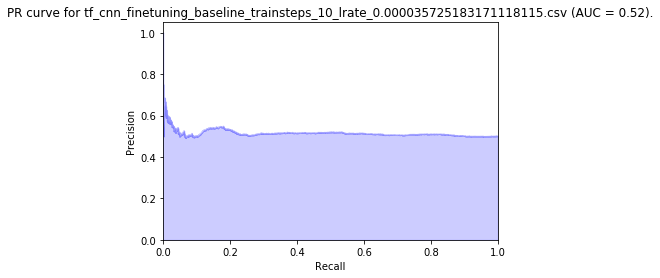

tf_cnn_finetuning_baseline_trainsteps_10_lrate_0.00007145036.csv
	ROC AUC: 0.5345936658977316
	PR AUC: 0.5340382114351637
	F1: 0.5161450571286637


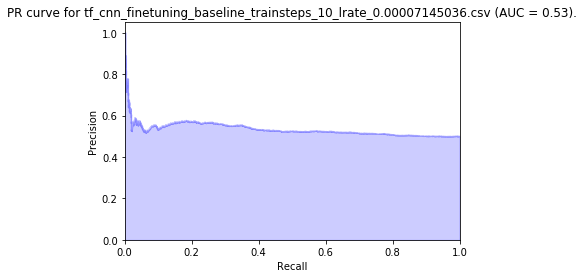

tf_cnn_finetuning_baseline_trainsteps_10_lrate_0.00017862591.csv
	ROC AUC: 0.5439316608996541
	PR AUC: 0.5405950152058164
	F1: 0.5096924269837168


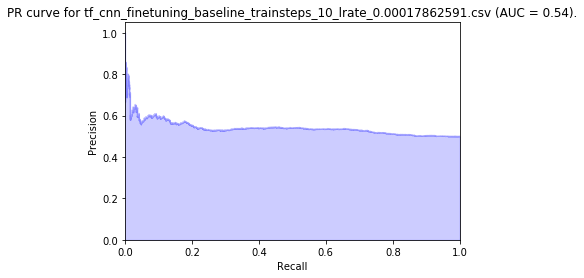

tf_cnn_finetuning_baseline_trainsteps_10_lrate_0.00035725183171118115.csv
	ROC AUC: 0.5360825163398693
	PR AUC: 0.5322311344675934
	F1: 0.5019166879631995


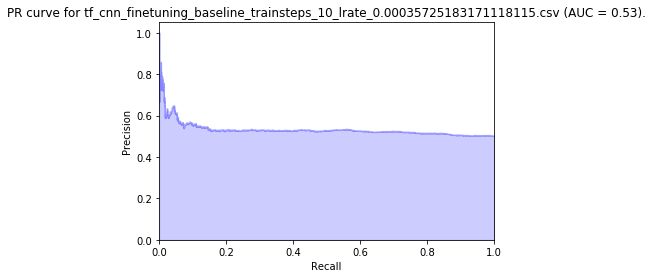

tf_cnn_finetuning_baseline_trainsteps_10_lrate_0.00071450366.csv
	ROC AUC: 0.5497510572856593
	PR AUC: 0.5362616078740785
	F1: 0.5026205450733752


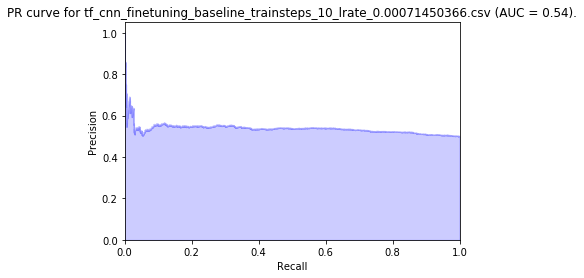

tf_cnn_finetuning_baseline_trainsteps_50_lrate_0.000035725183171118115.csv
	ROC AUC: 0.5390024269511727
	PR AUC: 0.5311372008070551
	F1: 0.4908328968046097


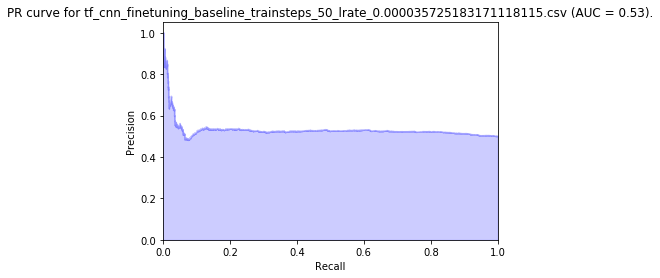

tf_cnn_finetuning_baseline_trainsteps_50_lrate_0.00007145036.csv
	ROC AUC: 0.5655858323721645
	PR AUC: 0.5497097697437794
	F1: 0.5146867689108395


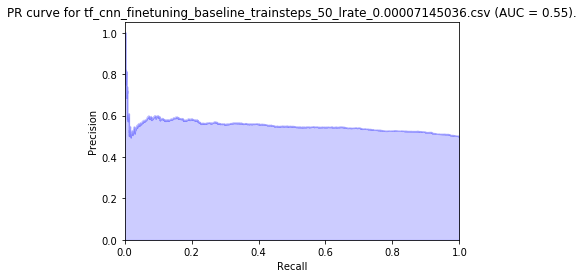

tf_cnn_finetuning_baseline_trainsteps_50_lrate_0.00017862591.csv
	ROC AUC: 0.5967469242599001
	PR AUC: 0.5693201046391112
	F1: 0.5343353200310962


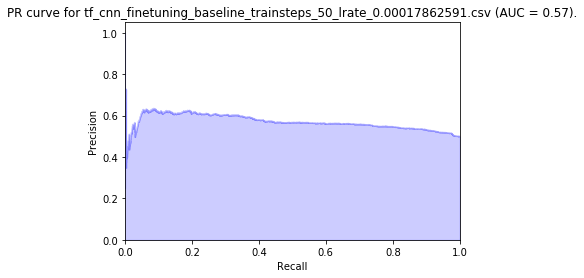

tf_cnn_finetuning_baseline_trainsteps_50_lrate_0.00035725183171118115.csv
	ROC AUC: 0.6054488658208381
	PR AUC: 0.5865292798671884
	F1: 0.5592875318066158


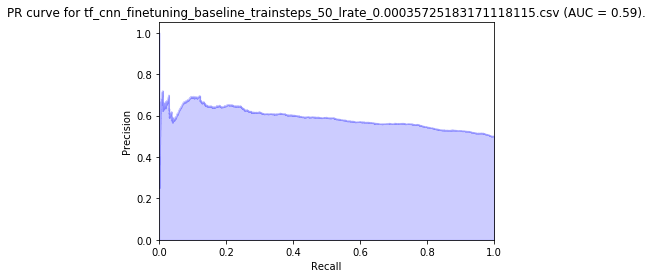

tf_cnn_finetuning_baseline_trainsteps_50_lrate_0.00071450366.csv
	ROC AUC: 0.6138069492502883
	PR AUC: 0.5963756428811708
	F1: 0.5671490225945672


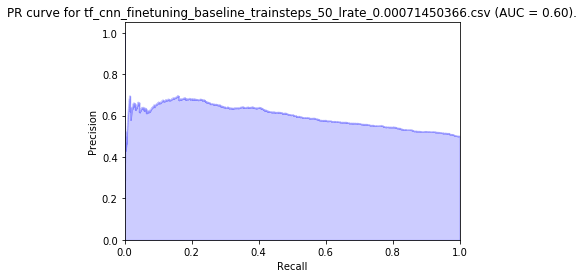

tf_cnn_finetuning_baseline_trainsteps_5_lrate_0.000035725183171118115.csv
	ROC AUC: 0.5001981209150327
	PR AUC: 0.5006347113124365
	F1: 0.5226223453370269


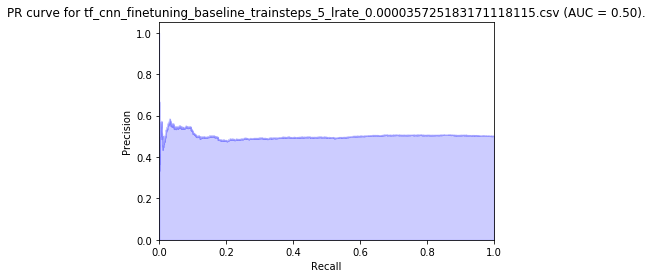

tf_cnn_finetuning_baseline_trainsteps_5_lrate_0.00007145036.csv
	ROC AUC: 0.5133380190311418
	PR AUC: 0.5132094143343884
	F1: 0.5078125


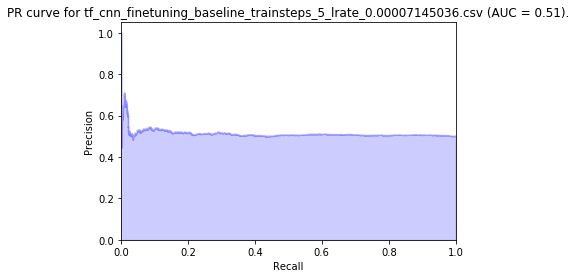

tf_cnn_finetuning_baseline_trainsteps_5_lrate_0.00017862591.csv
	ROC AUC: 0.5329835880430605
	PR AUC: 0.533350640821895
	F1: 0.5397051830718022


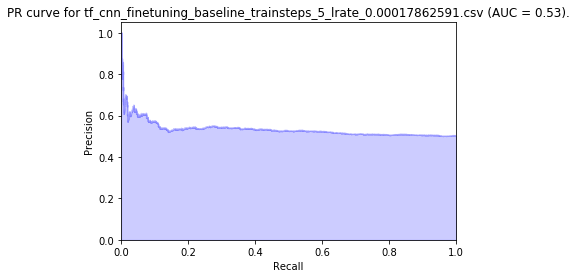

tf_cnn_finetuning_baseline_trainsteps_5_lrate_0.00035725183171118115.csv
	ROC AUC: 0.5290385909265667
	PR AUC: 0.5360030260635937
	F1: 0.5256683226874852


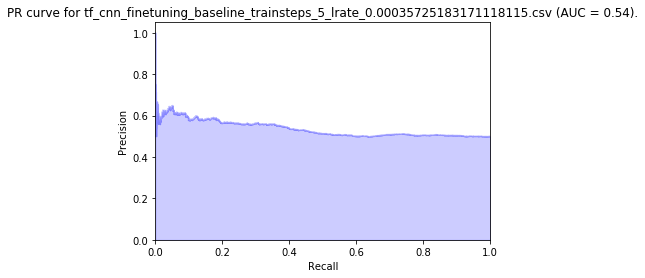

tf_cnn_finetuning_baseline_trainsteps_5_lrate_0.00071450366.csv
	ROC AUC: 0.5170893406382161
	PR AUC: 0.524446759852056
	F1: 0.5072713827951688


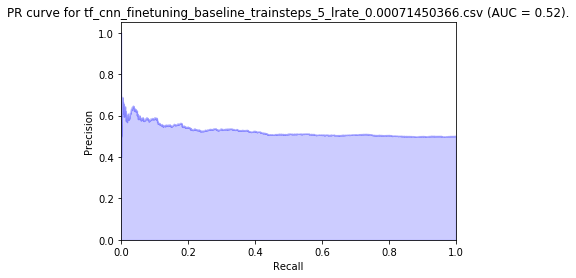

In [70]:
compute_metrics_from_dir(TF_CNN_VALID_RESULTS_DIR)

In [37]:
files[0]

'tf_cnn_finetuning_baseline_trainsteps_10_lrate_0.000035725183171118115.csv'

In [ ]:
def load_csv_predictions(pred_file):
    with file_io.FileIO(pred_file, 'r') as f:
      # prediction file needs to fit in memory.
      try:
        predictions = [json.loads(line) for line in f]
      except:
        predictions = []
    return predictions